In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, log_loss
from time import time

In [2]:
df1 = pd.read_csv('../data/match_data.csv')
X1 = df1.drop(columns=['Date', 'Team1', 'Team2', 'Score'])
y1 = df1['Score']
ds1_name = "match_data"
best_max_depth1 = 9
best_n_estimators1 = 300
best_min_s_s1 = 5

df2 = pd.read_csv('../data/cleaned_rounds_data.csv')
df2 = df2.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X2 = df2.drop(['round_winner'], axis=1)
y2 = df2['round_winner']
ds2_name = "rounds_data"
best_max_depth2 = 40
best_n_estimators2 = 150
best_min_s_s2 = 3

df3 = pd.read_csv('../data/cleaned_rounds_data_with_stats.csv')
df3 = df3.drop(columns=[f'player_{i}_{suffix}' for i in range(1, 11) for suffix in ['team_name', 'name']])
X3 = df3.drop(columns=['round_winner'])
y3 = df3['round_winner']
ds3_name = "rounds_data_with_stats"
best_max_depth3 = 25
best_n_estimators3 = 300
best_min_s_s3 = 7

datasets = [(X1, y1, ds1_name, best_max_depth1, best_n_estimators1, best_min_s_s1),
            (X2, y2, ds2_name, best_max_depth2, best_n_estimators2, best_min_s_s2),
            (X3, y3, ds3_name, best_max_depth3, best_n_estimators3, best_min_s_s3)]

Dataset: match_data with best_n_estimators=300, best_max_depth=9, best_min_samples_split=5
Time to fit and predict: 0.5725061893463135 seconds
              precision    recall  f1-score   support

           0       0.60      0.57      0.58       252
           1       0.60      0.63      0.61       259

    accuracy                           0.60       511
   macro avg       0.60      0.60      0.60       511
weighted avg       0.60      0.60      0.60       511

                 Predicted Negative  Predicted Positive
Actual Negative                 143                 109
Actual Positive                  97                 162
ROC AUC: 0.6611739290310719
Dataset: rounds_data with best_n_estimators=150, best_max_depth=40, best_min_samples_split=3
Time to fit and predict: 0.6034905910491943 seconds
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1148
           1       0.84      0.86      0.85      1190

    accuracy             

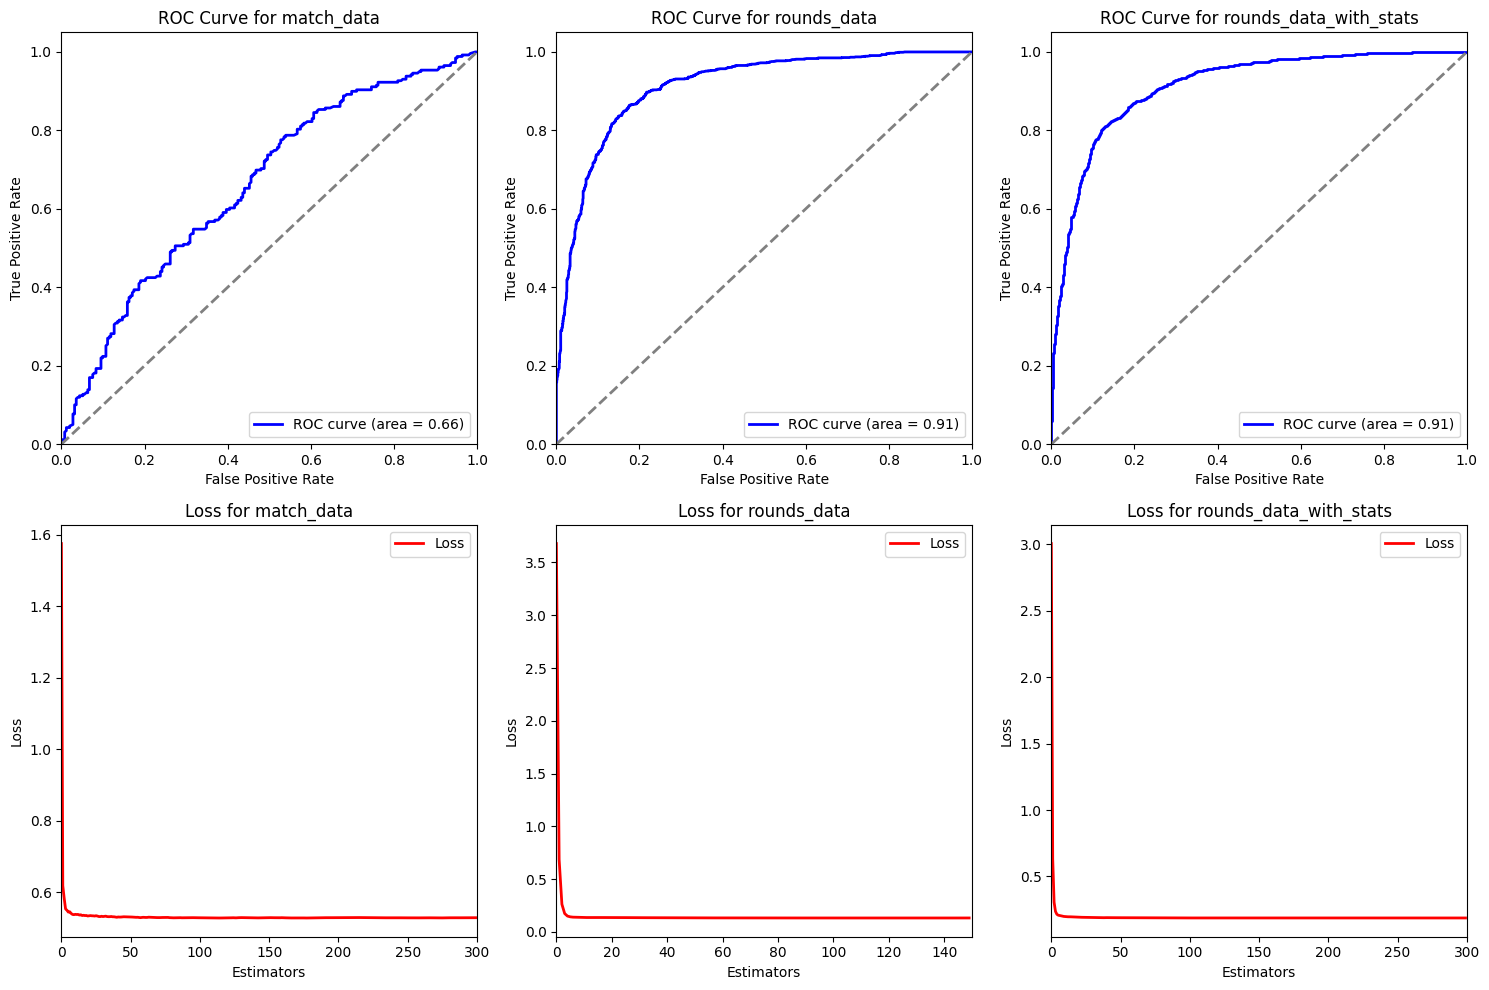

In [5]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for idx, (X, y, ds_name, best_max_depth, best_n_estimators, best_min_s_s) in enumerate(datasets):
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    model = RandomForestClassifier(criterion="log_loss", n_estimators=best_n_estimators, max_depth=best_max_depth, min_samples_split=best_min_s_s, random_state=42, n_jobs=-1)
    
    start_time = time()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)

    print(f"Dataset: {ds_name} with best_n_estimators={best_n_estimators}, best_max_depth={best_max_depth}, best_min_samples_split={best_min_s_s}")
    print(f"Time to fit and predict: {time() - start_time} seconds")
    
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'],
                                columns=['Predicted Negative', 'Predicted Positive'])
    print(conf_matrix_df)
    print(f"ROC AUC: {roc_auc_score(y_test, y_probs[:,1])}")
    fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])
    
    axs[0, idx].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, y_probs[:,1]):.2f})')
    axs[0, idx].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    axs[0, idx].set_xlim([0.0, 1.0])
    axs[0, idx].set_ylim([0.0, 1.05])
    axs[0, idx].set_xlabel('False Positive Rate')
    axs[0, idx].set_ylabel('True Positive Rate')
    axs[0, idx].set_title(f'ROC Curve for {ds_name}')
    axs[0, idx].legend(loc='lower right')

    losses = []
    cumulative_probs = np.zeros((X_train.shape[0], 2))
    for i, estimator in enumerate(model.estimators_):
        cumulative_probs += estimator.predict_proba(X_train)
        avg_probs = cumulative_probs / (i + 1)
        
        loss = log_loss(y_train, avg_probs)
        losses.append(loss)

    axs[1, idx].plot(range(best_n_estimators), losses, color='red', lw=2, label='Loss')
    axs[1, idx].set_xlim([0, len(losses)])
    axs[1, idx].set_xlabel('Estimators')
    axs[1, idx].set_ylabel('Loss')
    axs[1, idx].set_title(f'Loss for {ds_name}')
    axs[1, idx].legend(loc='upper right')


plt.tight_layout()
plt.show()